## Predicting Book Ratings from Goodreads Reviews ##

### Overview ###

Many of us look at product ratings online before we buy something. We often project these ratings as a collective sentiment towards a product. However, more often than not, these ratings can be very abstract and dynamic. For example, a study [[1]](#[1]) showed that bad weather can make people write more reviews and give lower ratings for things they bought before. This shows that ratings alone are not enough to tell how customers feel about a product. Sometimes, people may write similar reviews but give different ratings. It is easier for humans to express their opinions in words than in numbers.

New technology is increasingly making the idea of sentiment analysis more and more objective. A mathematical function can be derived numerically, to extract sentiment from reviews and project the same onto a number line. The use of an objective function can help reduce the abstract nature of product ratings. In this project, I want to make a model that can guess the ratings of books on Goodreads based on their reviews.

I used some simple methods to convert the reviews into vectors and train two models: Logistic Regression and Multinomial Naive Bayes. The goal was to predict the ratings given by readers based on the book reviews from goodreads.com. These models are not very complex compared to neural networks, but they performed well (80%) at guessing the ratings within one star difference.

In [1]:
import pandas as pd

from nltk import word_tokenize
import nltk
from matplotlib import pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

#importing the required data into python
data = pd.read_csv('goodreads_train.csv')
data.head(5)

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


In [2]:
#getting an overview of the data 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       900000 non-null  object
 1   book_id       900000 non-null  int64 
 2   review_id     900000 non-null  object
 3   rating        900000 non-null  int64 
 4   review_text   900000 non-null  object
 5   date_added    900000 non-null  object
 6   date_updated  900000 non-null  object
 7   read_at       808234 non-null  object
 8   started_at    625703 non-null  object
 9   n_votes       900000 non-null  int64 
 10  n_comments    900000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 75.5+ MB


In [3]:
#Considering only the features that are required 
data = data[['review_id','book_id','rating','review_text']]
data.head(5)

,review_id,book_id,rating,review_text
0,dfdbb7b0eb5a7e4c26d59a937e2e5feb,18245960,5,This is a special book. It started slow for ab...
1,a5d2c3628987712d0e05c4f90798eb67,16981,3,Recommended by Don Katz. Avail for free in Dec...
2,2ede853b14dc4583f96cf5d120af636f,28684704,3,"A fun, fast paced science fiction thriller. I ..."
3,ced5675e55cd9d38a524743f5c40996e,27161156,0,Recommended reading to understand what is goin...
4,332732725863131279a8e345b63ac33e,25884323,4,"I really enjoyed this book, and there is a lot..."


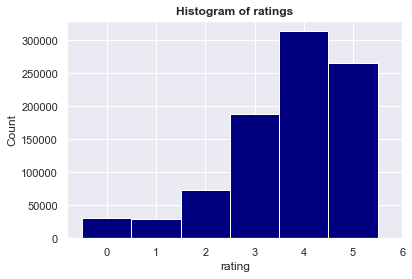

In [4]:
import seaborn as sns
import numpy as np
sns.set_theme()
ax = sns.histplot(x="rating", data=data, bins = [-.5,0.5,1.5,2.5,3.5,4.5,5.5], color= 'navy', alpha = 1)
ax.set_xticks(np.arange(0,7))
ax.grid('True')
ax.set_title('Histogram of ratings', weight= 'bold')
plt.show()

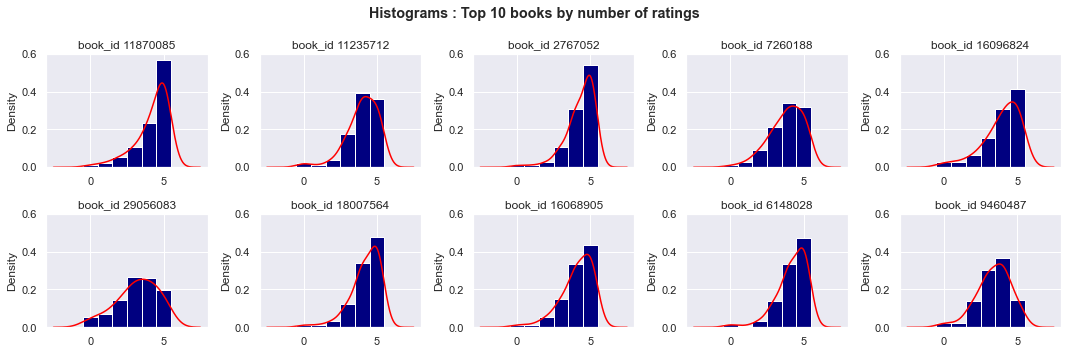

In [5]:
top_10 = data[['rating','book_id']].groupby('book_id').count().sort_values('rating',ascending = False).head(10).reset_index()
top_10_list = top_10['book_id'].to_list()

fig, ax = plt.subplots(2,5, figsize = (15,5))

k = 0 
for i in range(0,2):
    for j in range(0,5):
        data[data['book_id'].isin([top_10_list[k]])]['rating'].plot.hist(
            ax = ax[i][j],bins = [-.5,0.5,1.5,2.5,3.5,4.5,5.5], color= 'navy', alpha = 1, density = True)
        data[data['book_id'].isin([top_10_list[k]])]['rating'].plot(kind = 'kde',
            ax = ax[i][j], color= 'red', alpha = 1,bw_method=0.5)
        ax[i][j].set_ylim(0,0.6)
        ax[i][j].set_title('book_id {}'.format(top_10_list[k]))
        k+=1
        
plt.suptitle('Histograms : Top 10 books by number of ratings', weight = 'bold')
plt.tight_layout()
plt.show()


The red curve can be interpreted as a continuous probability distribution equivalent to the 6 rating bins. While the histograms exhibit Gaussian-like behaviour, they are not a perfect match. The flatter the curve, the more diverse the general opinion is. Conversely, sharper curves indicate a solid collective sentiment. Analysis of kurtosis of the distribution may give a better picture.

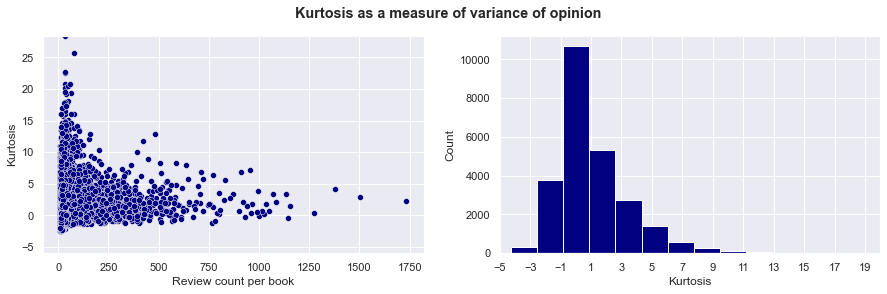

In [6]:
import warnings
warnings.filterwarnings("ignore")

kurtosis = data[['rating','book_id']].groupby('book_id').apply(pd.Series.kurtosis)['rating'].to_list()
count = data[['rating','book_id']].groupby('book_id').count()['rating'].to_list()

fig, ax = plt.subplots(1,2,figsize = (15,4))
kurtosis = np.array(kurtosis)
count = np.array(count)
sns.scatterplot(count[count>10],kurtosis[count>10], ax= ax[0], color= 'navy', alpha = 1)
ax[0].set_ylim(min(kurtosis),max(kurtosis))
ax[0].set_ylabel('Kurtosis')
ax[0].set_xlabel('Review count per book')

sns.histplot(kurtosis, bins = 20,ax=ax[1], color= 'navy', alpha = 1)
ax[1].set_xticks(np.arange(-5,20,2))
ax[1].set_xlim(-5,20)
ax[1].set_xlabel('Kurtosis')
plt.suptitle('Kurtosis as a measure of variance in opinion',weight = 'bold')
plt.show()

Kurtosis tells you how pointy a distribution is. A very high kurtosis means that most people feel the same way about something. A negative kurtosis means that the distribution is flat and people have different opinions. For example, if a book has a negative kurtosis, it means that some people like it and some people don’t.

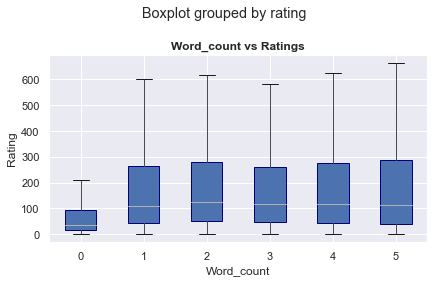

In [7]:
data['word_count'] = data['review_text'].apply(lambda x: len(str(x).split(' ')))
data.boxplot(column = 'word_count', by='rating', showfliers = False, patch_artist = True
            ,boxprops=dict(color='navy'))
plt.tight_layout()
plt.ylabel('Rating')
plt.xlabel('Word_count')
plt.title('Word_count vs Ratings', weight = 'bold')
plt.show()

With the exception of 0-rated reviews, the median word count falls within a narrow range of around 100 words. While one-hot encoding serves to eliminate variance in the number of input features, a minimum word count of 20 is being enforced. For the sake of representativeness, a training set of 10,000 data points per rating score is used in this analysis.

### Data preprocesing and feature engineering ###

Sentences were preprocessed by removing stopwords. Then, lemmatization was applied to unify words with the same meaning. Sentences were converted into arrays of vectors, each vector representing the words and a pair-wise combination of words (one-hot encoding).

In [8]:
import numpy as np
#sentances and ratings will now be extracted into lists
sentances = []
ratings = []
for i in range(0,6):
    df1 = data[(data['rating'] == i) & (data['word_count'] > 20)][:10000] # This ensures a representative sample
    ratings.extend(df1['rating'].tolist())
    for index, row in df1.iterrows():
        sentances.append(row['review_text'].lower())
ratings = np.array(ratings)

In [9]:
master= []
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
filtsentances = []

for s in sentances:
    temp = s.split()
    filt_words = [lemmatizer.lemmatize(w) for w in temp if w not in stop_words] # removing stopwords and lemmatizing
    filtsentances.append(' '.join(filt_words))
    master.extend(filt_words)

master = set(master)

vect = CountVectorizer(ngram_range = (1,2))
v = vect.fit(filtsentances)
v1 = v.transform(filtsentances)

In [10]:
import random
indexes = np.arange(1,60000)
from sklearn.model_selection import train_test_split
train, test= train_test_split(indexes , test_size=0.30, random_state=42)

### Multinomial Naive Bayes Model ###

In [11]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.metrics import f1_score

clf = MultinomialNB()
clf.fit(v1[train], ratings[train])
y_pred_MNB = clf.predict(v1[test])


#Evaluate the performance of the classifier on the test data
accuracy = clf.score(v1[test], ratings[test])
f1 = f1_score(ratings[test],y_pred_MNB, average = 'macro')

print("Accuracy on test set: ", round(accuracy,3))
print("F1- score:", round(f1,3))

Accuracy on test set:  0.43
F1- score: 0.385


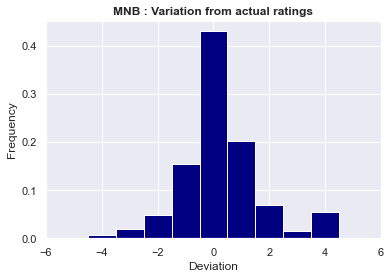

In [12]:
plt.hist(np.array(y_pred_MNB)-np.array(ratings[test]), bins = 10, rwidth=1,align = 'left',density=True, color = 'navy')
plt.grid(True)
plt.xlim(-6,6)
plt.title('MNB : Variation from actual ratings', weight = 'bold')
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.show()

The Naive Bayes Model did not perform well at making precise predictions, as the accuracy is only 43% for an exact match. However, examining the distribution of deviation from the actual ratings, we find that around 79% of the predictions fall within one star ratings of the true rating.

In [13]:
def onestar_eff(y_pred,ratings,test_indexes):
    s= 0
    for i in range(2,6):
        s+=len(y_pred[abs(np.array(y_pred)-np.array(ratings[test_indexes]))==i])/len(y_pred)
    return (1-s)

print('Accuracy within +/- 1 :',round(onestar_eff(y_pred_MNB,ratings,test),2)*100,'%')

Accuracy within +/- 1 : 79.0 %


### Logistic Regression ###

After multiple runs, hyperparameters such as penalty and regularization factor C were chosen. This choice factored in an optimum combination of training and testing accuracies

In [ ]:
# from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', random_state=42, solver = 'liblinear', C=0.03 )
clf.fit(v1[train], ratings[train])

# Evaluate the performance of the classifier on the test data
accuracy = clf.score(v1[train], ratings[train])
print("Accuracy: ", accuracy)

In [35]:
y_pred_LR = clf.predict(v1[test])

accuracy = clf.score(v1[test], ratings[test])
f1 = f1_score(ratings[test],y_pred_LR, average = 'macro')

print("Accuracy on test set: ", round(accuracy,3))
print("F1- score:", round(f1,3))
      

Accuracy on test set:  0.505
F1- score: 0.502


This LR model's accuracy and f-1 score are clearly better than that of MNB. The 30% deviation lies within the one-star difference, making the LR model 80% accurate in predicting ratings within an error of one star.

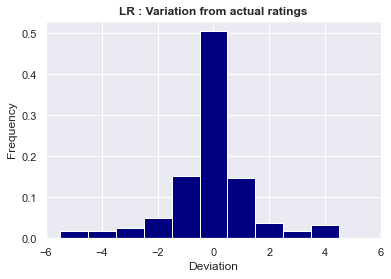

In [16]:
plt.hist(np.array(y_pred_LR)-np.array(ratings[test]), bins = 10, rwidth=1,align = 'left',density=True, color = 'navy')
plt.grid(True)
plt.xlim(-6,6)
plt.title('LR : Variation from actual ratings', weight = 'bold')
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.show()

In [17]:
print('Accuracy within +/- 1 :',round(onestar_eff(y_pred_LR,ratings,test),2)*100,'%')

Accuracy within +/- 1 : 80.0 %


### Conclusion ###

In this project, I compared two models for rating prediction based on book reviews: Logistic Regression and Multinomial Naive Bayes. I found that Logistic Regression with tuned parameters outperformed MNB, achieving a classification accuracy of 50%. Moreover, it was 80% accurate in its predictions within an error margin of 1 star. For future work, I plan to explore the effectiveness of more powerful models such as SVM and neural networks.

### References ###

<a id="[1]"></a> [1]  https://www.researchgate.net/publication/358219285_Offline_Context_Affects_Online_Reviews_The_Effect_of_Post-Consumption_Weather